<h2>Abdul Wahab</h2>
<h3>Natural Language Identification (Embedded Devices) - Using Deep Neural Network</h3>

<p>
In this project, I pulled text data from TED Talks in 63 languages.
I converted the text into its binary representation of 4 byte for each letter, utf-8 encoding. 
Using Tensorflow, I trained a simple deep neural network to classify input languages. I acheived 91% accuracy with mostly spoken 17 languages and 80% accuracy with all 56 languages.
</p>

<p> 
Dataset: https://www.kaggle.com/wahabjawed/text-dataset-for-63-langauges
</p>

In [104]:

# Required libraries

%config IPCompleter.greedy=True
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
tf.get_logger().setLevel('ERROR')
from tensorflow.compat.v2.keras.models import Sequential
from tensorflow.compat.v2.keras.layers import Dense, LSTM, Bidirectional, Dropout,Conv1D,GlobalMaxPooling1D
from tensorflow.compat.v2.keras import initializers, optimizers
from keras.callbacks import ModelCheckpoint, TensorBoard

import tensorflow_model_optimization as tfmot

from tflite_support import flatbuffers
from tflite_support import metadata as _metadata
from tflite_support import metadata_schema_py_generated as _metadata_fb

import numpy as np
import pandas as pd
import re
from unidecode import unidecode
from array import array
from nltk.tokenize import sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
import os
import matplotlib.pyplot as plt
import seaborn as sns


<h2>Configuration</h2>

In [108]:

# Map language index to natural language

labels_extended = { 
          0: ['Vietnamese','vi'], 1:['Albanian','sq'], 2:['Arabic','ar'],
          3: ['Armenian','hy'], 4: ['Azerbaijani','az'], 
          5: ['Belarusian','be'],6: ['Bengali','bn'], 
          7: ['Bosnian','bs'], 8: ['Bulgarian','bg'], 
          9: ['Burmese','my'], 10: ['Catalan', 'ca'],
          11: ['Chinese Simplified','zh-cn'], 12: ['Chinese Traditional','zh-tw'],
          13: ['Chinese Yue','zh'], 14: ['Croatian','hr'],
          15: ['Czech','cs'], 16: ['Danish','da'],
          17: ['Dutch','nl'], 18: ['English','en'],
          19: ['Esperanto','eo'], 20: ['Estonian','et'],
          21: ['Finnish','fi'], 22:['French','fr'],
          23: ['Galician','gl'], 24: ['Georgian','ka'], 
          25: ['German','de'],26: ['Urdu','ur'],
          27: ['Gujarati','gu'], 28: ['Hebrew','he'], 
          29: ['Hindi','hi'], 30: ['Hungarian', 'hu'],
          31: ['Indonesian','id'], 32: ['Italian','it'],
          33: ['Japanese','ja'], 34: ['Korean','ko'],
          35: ['Latvian','lv'], 36: ['Lithuanian','lt'],
          37: ['Macedonian','mk'], 38: ['Malay','ms'],
          39: ['Marathi','mr'], 40: ['Mongolian','mn'],
          41: ['Norwegian','nb'], 42: ['Persian','bg'],
          43: ['Polish','pl'], 44: ['Portuguese','pt'],
          45: ['Romanian','ro'],46: ['Russian','ru'], 
          47: ['Serbian','sr'], 48: ['Slovak','sk'], 
          49: ['Slovenian','sl'], 50: ['Spanish', 'es'],
          51: ['Swedish','sv'], 52: ['Tamil','ta'],
          53: ['Thai','th'], 54: ['Turkish','tr'],
          55: ['Ukrainian','uk']
          }



labels_standard = { 
        0: ['Indonesian','id'], 1:['English','en'], 2:['German','de'],
        3: ['Turkish','tr'],4:['Hindi','hn'],
        5: ['Spanish','es'],6: ['Bengali','bn'], 
        7: ['French','fr'], 8: ['Italian','it'], 
        9: ['Dutch','nl'], 10: ['Portuguese', 'pt'],
        11: ['Swedish','sv'], 12: ['Russian','ru'],
        13: ['Czech','cs'], 14: ['Arabic','ar'],
        15: ['Chinese Traditional','zh-cn'],16: ['Persian','fa']
}


#['STANDARD','EXTENDED']
# STANDARD supports 16 languages
# EXTENDED supports 56 languages

TYPE = 'STANDARD'



# assign number of languages to process

if(TYPE =='STANDARD'):
    LABEL = labels_standard
else:
    LABEL = labels_extended


# regular expression pattern used to filter out data

pattern = r'[^\w\s]+|[0-9]'

# Max length of input text
MAX_INPUT_LENGTH = 13

#MAX data length for each language to balnace the dataset
MAX_LENGTH_DATA = 300000

<h2>Helper Functions</h2>

In [109]:
# Helper Functions

def read_languages_data(path):
    '''
    Goal: Read language data from file path into a list containing one massive string
    
    @param path: (string) file path pointing to the raw natural language text
    @return language_transcription: (list) language_transcription is a list of one string containing the whole text
    '''
    with open(path) as f:
        language_transcription = f.read()
        language_transcription = language_transcription[:MAX_LENGTH_DATA]
    return language_transcription

def clean_sentences(sentences):
    '''
    Goal: Filter out non predictive text about speaker using regular expression pattern
    
    @param sentences: (list) sentences is a list of strings, where each string is a sentence.
                       Note: The raw language_transcription should be tokenized by sentence prior
                       to being passed into this function.
    '''
    return re.sub(pattern,'',sentences)

def test_languages(X_test, true_values, predictions):
    '''
    Goal: Visualize the ~99% prediction accuracy by comparing,
        1. natural language sentence
        2. predicted natural language
        3. true natural language
    
    @param X_test: (np.array) X_test is a np.array containing the unseen data from the test set
    @param true_values: (np.array) true_values is a np.array containing the true language_index labels
    @param predictions: (np.array) predictions is a np.array containing the predicted language_index labels
    '''
    
    true_values = np.array(true_values)
    
    for i, sentence in X_test.iterrows():
        prediction = predictions[i]
        true_value = true_values[i]
        print(i)
        print("Prediction: " + LABEL[prediction][0])
        print("Actual Language: " + LABEL[true_value[0]][0])
        print("Input Sentence: ")
        print(sentence)
        print('\n')

def combine_language_data(sentences, language_index):
    '''
    Goal: Transform list of string sentences into np.array, and stack horizontally with an np.array containing 
          the sentence's language_index, which maps to the sentence language. Essentially, apply label to data.
    
    @param sentences: (list) sentences is a list of cleaned strings
    @param language_index: (float) language_index is a float that maps to a specific language in the labels dictionary
    @return language_data: (np.array) return an np.array of shape (# of sample sentences, 2 )
    '''
    
    
    MIN_LENGTH = 2
    
    if(LABEL[language_index][1] =='ja' or LABEL[language_index][1] =='th'):
        MIN_LENGTH=1
    
    temp_word_list=[]
    
    words = sentences.split();
    for word in words:
        if len(word) <= MAX_INPUT_LENGTH and len(word) > MIN_LENGTH:
            entry = []
            entry.append(word)
            entry.append(language_index)
            entry.extend(convertTextToBinary(word))
            temp_word_list.append(entry)
    return temp_word_list


def convertTextToBinary(word):
    word_vec = []
    vec = ''
    n = len(word)
    for i in range(n):
        current_letter = word[i]
        ind = ord(current_letter)
        placeholder = bin(ind)[2:].zfill(32)
        vec = vec + placeholder
    vec = vec.zfill(32*MAX_INPUT_LENGTH)
    for digit in vec:
        word_vec.append(int(digit))
    return word_vec
    
    
def preproccess_raw_data(file_paths):
    '''
    Goal: Run all data preprocessing helper functions
    
    @param file_paths: (list) file_paths is a list of string file paths. Each file path string
                        points to a raw text file from the European Parliament Proceedings.
    @return languages: (np.array) languages is a 2D np.array of shape (# sentences, 2)
                        The first dimension has the a sentence, and the second dimension
                        has the language_index label, that maps to the language.
    '''
    
    word_list=[]
    
    for path in file_paths:
        
        print(f"processing {path}")
        # Read all raw text data from file paths
        language_transcriptions = read_languages_data(path[1])

        # Remove information about speakers using a regular expression pattern
        language_transcriptions = clean_sentences(language_transcriptions)

        # Combine each language with its language_index
        word_list.extend(combine_language_data(language_transcriptions,path[0]))


    return word_list
    

In [110]:
# Get all file paths

file_paths = [ [language , os.getcwd() + '/dataset/'+LABEL[language][0]+'.txt'] for language in LABEL ]

# Preprocess all raw text into a form suitable for Binary Encoding
languages = preproccess_raw_data(file_paths)

processing [0, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Indonesian.txt']
processing [1, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/English.txt']
processing [2, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/German.txt']
processing [3, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Turkish.txt']
processing [4, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Hindi.txt']
processing [5, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Spanish.txt']
processing [6, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Bengali.txt']
processing [7, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/French.txt']
processing [8, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Italian.txt']
processing [9, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Dutch.txt']
processing [10, '/Users/abdulwahab/Desktop/BitBucket/lang-detect/dataset/Portuguese.txt']
processing [11, '/Users/abdulwahab/Desktop/BitBucket/

In [111]:
df_languages = pd.DataFrame(languages)
display(df_languages.head(10))

,0,1,2,3,4,5,6,7,8,9,...,408,409,410,411,412,413,414,415,416,417
0,Bagi,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
1,saya,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
2,cerita,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1
3,ini,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
4,dimulai,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
5,dari,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,0,0,1
6,tahun,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,1,1,1,0
7,yang,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,1,1
8,lalu,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,0,1
9,ketika,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,1


In [112]:
df_languages.shape

(607641, 418)

In [113]:
# Split data into raw features and labels

# the second column is the target
language_targets = df_languages.iloc[1:, 1:2]

# from second to last column are features
language_features = df_languages.iloc[1:, 2:]

<h3>Ensure Dataset is relativley balanced.</h3>

In [114]:
unique, counts = np.unique(language_targets, return_counts=True)
dict(zip(unique, counts))

{0: 41660,
 1: 35301,
 2: 41639,
 3: 35044,
 4: 22321,
 5: 36005,
 6: 30494,
 7: 36856,
 8: 35476,
 9: 38556,
 10: 36714,
 11: 41868,
 12: 34723,
 13: 36740,
 14: 44200,
 15: 17487,
 16: 42556}

In [115]:
# Split data into training and test set
# Train on 80% of data, Test on remaining 20%

x_train, x_test, y_train, y_test = train_test_split(language_features, 
                                                    language_targets,
                                                    test_size = 0.2,
                                                    random_state = 42)

<h2>Deep Neural Network - Helper Function</h2>


In [116]:

def createModelStandard():
    initializer = initializers.he_uniform()
    model = Sequential()
    model.add(Dense(416, activation='relu', kernel_initializer=initializer, input_dim=x_train.shape[1]))
    model.add(Dense(512, activation='relu', kernel_initializer=initializer))
    model.add(Dense(128, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.15))
    model.add(Dense(len(LABEL), activation='softmax'))
    model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
    
    return model


def createModelExtended():
    initializer = initializers.he_uniform()
    model = Sequential()
    model.add(Dense(416, activation='relu', kernel_initializer=initializer, input_dim=x_train.shape[1]))
    model.add(Dense(1024, activation='relu', kernel_initializer=initializer))
    model.add(Dense(256, activation='relu', kernel_initializer=initializer))
    model.add(Dropout(0.15))
    model.add(Dense(len(LABEL), activation='softmax'))
    model.summary()
    
    model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(1e-3), metrics=['accuracy'])
    
    return model
    
def loadWeights():
    # Evaluate the model
    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

    model.load_weights(f'weights/{TYPE}/weights_{TYPE}.chk')

    # Re-evaluate the model
    loss, acc = model.evaluate(x_test, y_test, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    
    
def generateMetadataTfLiteModel(model):
    """ ... """
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = "Language Identification"
    model_meta.description = ("Identify the language of a very short input text "
                             "from the set of 16/56 languages")
    model_meta.version = "v1"
    model_meta.author = "Abdul Wahab"
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")
    
    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    
    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    metadata_buf = b.Output()
    
    populator = _metadata.MetadataPopulator.with_model_file(model)
    populator.load_metadata_buffer(metadata_buf)
    populator.populate()
    
    return model


def quantizedModel(model):
    print('using quantization aware training')
    
    quantize_model = tfmot.quantization.keras.quantize_model

    # q_aware stands for for quantization aware.
    q_aware_model = quantize_model(model)

    # `quantize_model` requires a recompile.
    q_aware_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])

    q_aware_model.summary()
    
    return q_aware_model
    

def exportTfLiteModel(model):
    
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimization = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    # Save the model.
    with open(f'tflite-model/LanguageDetect-{TYPE}.tflite', 'wb') as f:
      f.write(tflite_model)
    
    generateMetadataTfLiteModel(f'tflite-model/LanguageDetect-{TYPE}.tflite')
    


<h2>Deep Neural Network - Training From Scratch</h2>


In [117]:
#create model

if(TYPE =='STANDARD'):
    model = createModelStandard()
else:
    model = createModelExtended()


# Train model and save the weights

filepath = f"weights/{TYPE}/weights_{TYPE}.chk"
checkpoint = ModelCheckpoint(filepath, verbose=1, save_weights_only=True)
callbacks_list = [checkpoint]


#model = quantizedModel(model)

model.fit(x_train, y_train, epochs=10, batch_size=1000, validation_data=(x_test, y_test), callbacks=callbacks_list)

exportTfLiteModel(model)

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 416)               173472    
_________________________________________________________________
dense_57 (Dense)             (None, 512)               213504    
_________________________________________________________________
dense_58 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_59 (Dense)             (None, 17)                2193      
Total params: 454,833
Trainable params: 454,833
Non-trainable params: 0
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGR

In [118]:
# Make predictions on unseen test data with trained classifier

predictions_perbability = model.predict(x_test)
predictions = []

for i in range(len(predictions_perbability)):
    predictions.append(np.argmax(predictions_perbability[i]))
    


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [119]:
# create label score

language_label = [val[0] for val in LABEL.values()]


# Measure accuracy

accuracy_score(y_test,predictions)

0.9067786847475479

<h1>Classification Report</h1>

In [120]:
print(classification_report(y_test, predictions, target_names=language_label))

                     precision    recall  f1-score   support

         Indonesian       0.94      0.95      0.94      8347
            English       0.93      0.94      0.93      6992
             German       0.91      0.88      0.90      8267
            Turkish       0.90      0.92      0.91      6959
              Hindi       0.99      0.99      0.99      4536
            Spanish       0.68      0.76      0.72      7220
            Bengali       1.00      1.00      1.00      6058
             French       0.89      0.87      0.88      7407
            Italian       0.86      0.83      0.84      7067
              Dutch       0.87      0.87      0.87      7700
         Portuguese       0.76      0.74      0.75      7379
            Swedish       0.90      0.91      0.90      8385
            Russian       1.00      1.00      1.00      7000
              Czech       0.95      0.94      0.94      7267
             Arabic       0.96      0.96      0.96      8821
Chinese Traditional    

[Text(0, 0.5, 'Indonesian'),
 Text(0, 1.5, 'English'),
 Text(0, 2.5, 'German'),
 Text(0, 3.5, 'Turkish'),
 Text(0, 4.5, 'Hindi'),
 Text(0, 5.5, 'Spanish'),
 Text(0, 6.5, 'Bengali'),
 Text(0, 7.5, 'French'),
 Text(0, 8.5, 'Italian'),
 Text(0, 9.5, 'Dutch'),
 Text(0, 10.5, 'Portuguese'),
 Text(0, 11.5, 'Swedish'),
 Text(0, 12.5, 'Russian'),
 Text(0, 13.5, 'Czech'),
 Text(0, 14.5, 'Arabic'),
 Text(0, 15.5, 'Chinese Traditional'),
 Text(0, 16.5, 'Persian')]

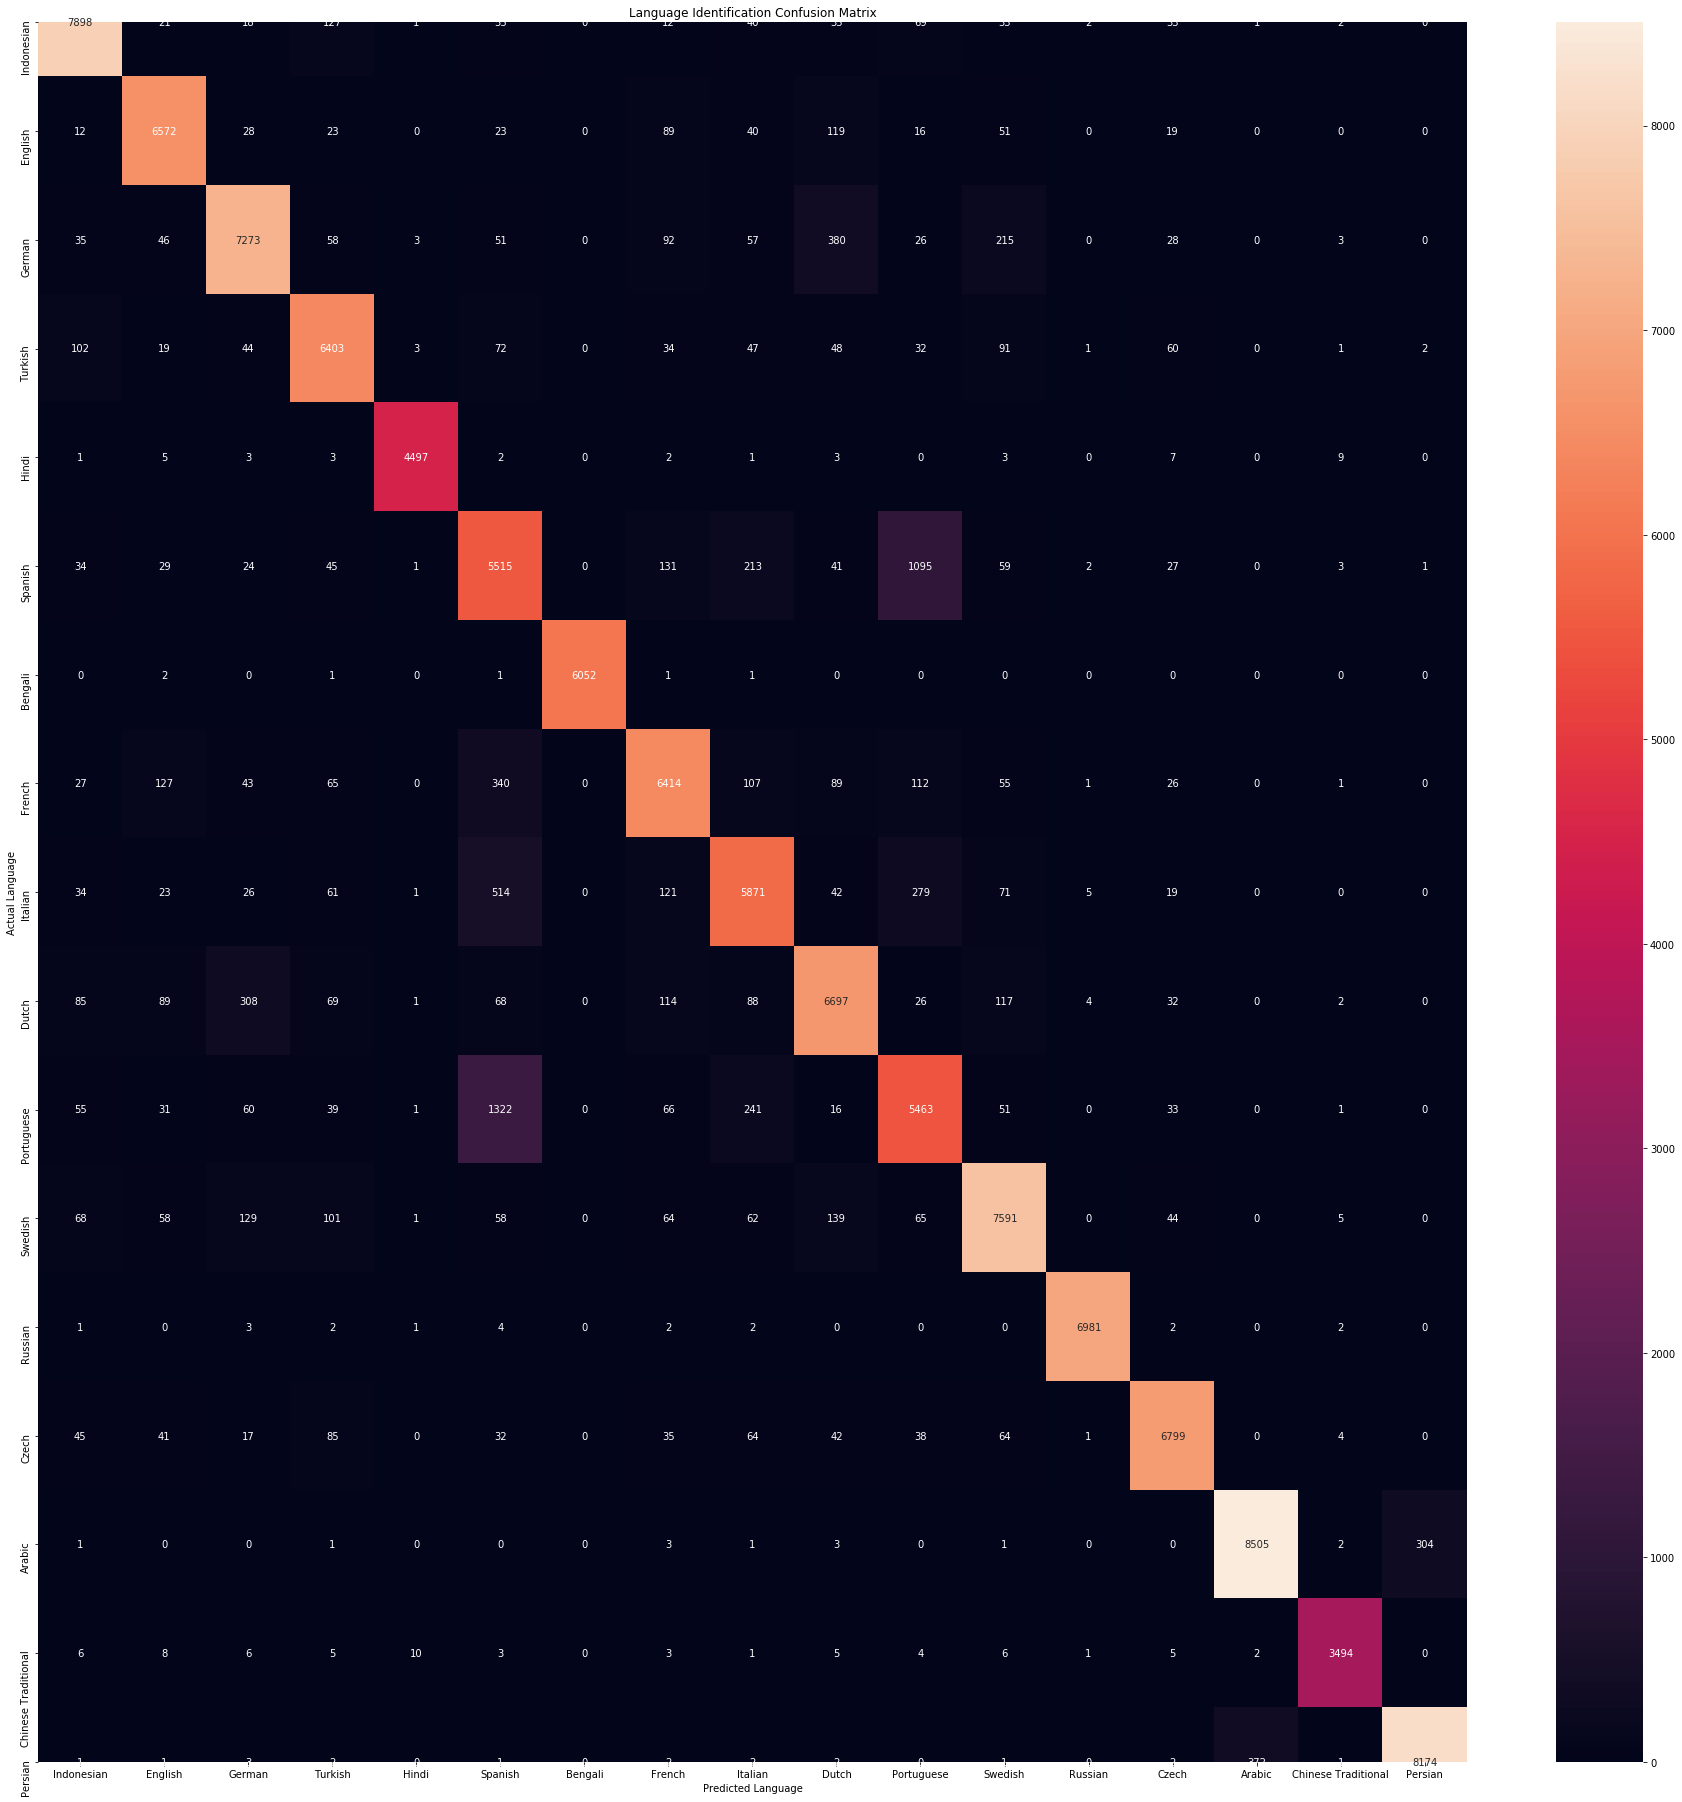

In [121]:
plt.figure(figsize=(32, 32))
cm = confusion_matrix(y_test, predictions)

ax = sns.heatmap(cm, annot = True, fmt = "d")

ax.set_xlabel('Predicted Language')
ax.set_ylabel('Actual Language')
ax.set_title('Language Identification Confusion Matrix')
ax.set_xticklabels(language_label)
ax.set_yticklabels(language_label)

<h1> 21x21 Confusion Matrix</h1>

<p> 
The well defined diagonal is a visual representation 
of the good performance of this language classifier.
Although this model performs quite well, there are a few misclassifications.
The confusion matrix gives insight into where the model makes errors.
</p>

In [73]:
plt.show()

In [103]:
# Visualize Performance

test_languages(x_test, y_test, predictions)

368717
Prediction: Catalan
Actual Language: Catalan
Input Sentence: 
2      0
3      0
4      0
5      0
6      0
      ..
413    1
414    0
415    1
416    0
417    1
Name: 368717, Length: 416, dtype: int64




IndexError: list index out of range